<img src="../../../../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Python Bootcamp and Summer Workshop on the Dynamic Brain</h1> 
<h3 align="center">August, 2018</h3> 

In [1]:
import sys, os
import pprint
import json
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h1 align="center">Modeling a coupled excitatory-inhibitory (E-I) network with DiPDE/popnet </h1> 

<p>In this tutorial, we will demonstrate simulation of an E-I network consisting of homogenous excitatory (E) and inhibitory (I) populations using the DiPDE simulator. 
<p>In this example, only the excitatory (E) population is being driven by excitatory input from the external (Ext) population.</div>

<img src="../../../Modeling/popnet_notebook/schematics_png/DiPDE_ei_net.png" alt = Drawing style = "width: 500px;"> 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h1> Building the network</h1>
<p>We will build the network step-by-step as follows:
<p>1) Create/parameterize the nodes (populations) in the internal network, namely the E and I populations
<p>2) Create/parameterize the external population. 
<p>3) Create/parameterize the edge (connection) from the external population to the E population.
<p>4) Connect the E population to the I population
<p>5) Run simulation and observe output
<p>6) Exercise: Connect I to E and explore how the outputs change</div>

In [2]:
#Create a folder called network. 
#Within this folder, we create a folder'recurrent_network' where the nodes and edges in our example will be saved
directory_name = os.path.join('network', 'recurrent_network')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p> We will explore the directory structure for saving nodes and edges later. For now, just note that we will be creating node and edge parameter files and storing them in the 'network' folder </div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2> 1) Building E and I nodes </h2>

<p>Let's start with creating a network object and add a single Excitatory population, followed by an Inhibitory population</div>

<img src="../../../Modeling/popnet_notebook/schematics_png/ei_pop.png" alt = Drawing style = "width: 500px;"> 

In [3]:
#Import the NxNetwork module from modelingsdk. This module allows us to create a network object
#to which we can add nodes and edges respectively. 
from bmtk.builder.networks import NetworkBuilder

#Create network object
net = NetworkBuilder('V1')

In [4]:
# Add 'E' node to 'net'
net.add_nodes(pop_name='excitatory', 
              ei='e',
              model_type='population',
              model_template='dipde:Internal',
              dynamics_params='excitatory_pop.json')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p> The variable 'node_type_id' is a label here that keeps track of a particular node; we can change the parameters associated with any node by specifying the node_type_id, without creating additional nodes.
<p> The default parameters for the excitatory population are stored in the json file. Let's see what they are. We will see below how the default parameters can be changed </div>

In [5]:
#Load the json file

with open('components/pop_models/excitatory_pop.json') as exc_data:
    exc_prs = json.load(exc_data)

#Print the parameters    
pprint.pprint(exc_prs)

{'approx_order': None,
 'dv': 0.0001,
 'record': True,
 'tau_m': 0.0429,
 'update_method': 'gmres',
 'v_max': 0.02,
 'v_min': -0.05}


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2> What do these parameters correspond to? </h2>
<p>approx_order: None,      
<p>dv: 0.0001      ->        grid-size for the membrane potential (in volts)
<p>record: True            
<p>tau_m: 0.0429   ->    membrane time-constant for each neuron in the population (in seconds)
<p>update_method': gmres  -> internal solver-specific method 
<p>v_max: 0.02,           ->   threshold membrane potential (in volts)
<p>v_min: -0.05           ->   resting membrane potential   (in volts)</div>            

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<h3> Exercise 1.1: </h3>

<p>Follow the steps above to add an 'I' node (inhibitory population) to the network. You can set the node_type_id to 1 and replace 'excitatory' with 'inhibitory' for the other two fields.</div>  

In [6]:
# Add 'I' node to 'net'
net.add_nodes(pop_name='inhibitory', 
              ei='i',
              model_type='population',
              model_template='dipde:Internal',
              dynamics_params='inhibitory_pop.json')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p>Now that we have created the nodes and added them to the network, the next step is to save the nodes' information to a .csv file </div>

In [7]:
#Save node information. The columns to be saved in this file are set by the user. Note that node_type_id is needed here
net.save_nodes(nodes_file_name='nodes.h5', node_types_file_name='node_types.csv', output_dir=directory_name)

In [8]:
# Let's display what is contained in the node_types file.
from bmtk.analyzer import nodes_table
nodes_table('network/recurrent_network/nodes.h5', 'V1')

,node_id,node_type_id
0,0,100
1,1,101


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2> 2) Building the Ext input node (as part of a separate 'Ext_input network')</h2>
<p>Along the same lines as for the E-I network, we will now create an external input network with a single node</div>

<img src="../../../Modeling/popnet_notebook/schematics_png/ei_ext_pop.png" alt = Drawing style = "width: 500px;"> 

In [9]:
#Create input network object
Ext_input = NetworkBuilder("Ext_input")

#Add 'Ext' node to Ext_input 
Ext_input.add_nodes(pop_name='input_filter', 
                    ei='e',
                    model_type='virtual',
                    model_template='dipde:External')

#Create a separate directory for external inputs and provide filename to save to:
input_directory_name = 'network/source_input/'

#if not os.path.exists(input_directory_name):
#    os.makedirs(input_directory_name)

#input_models_file = input_directory_name + 'input_node_types.csv'

#Save node information to file. 
#Ext_input.save_types(filename=input_models_file, columns=['node_type_id','level_of_detail','ei', 'pop_name'])
Ext_input.save_nodes(nodes_file_name='nodes.h5', node_types_file_name='node_types.csv', output_dir=input_directory_name)


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p> The steps used above are the same as those used for creating the E and I nodes.
<p>The only difference is that we have introduced two additional parameters 'ei' and 'model_type' in creating this node. 

<p>Setting ei = 'e' specifies that the input is excitatory. 
<p>Setting model_type = 'virtual' specifies that the external input arises from filter level models. 
<p>This will not be important right now, but will become clear when we work through the biophysical example. </div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<h3> Exercise 1.2 : </h3>
<p>Display what is contained in the input_node_types file that you just saved </div>

In [10]:
input_node_types_DF = pd.read_csv('network/source_input/node_types.csv', sep = ' ')
input_node_types_DF

,node_type_id,ei,pop_name,model_template,model_type
0,100,e,input_filter,dipde:External,virtual


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2> 3) Creating the edge from Ext to E </h2>
<p>Now we will create the edge connecting Ext population to E population </div>

<img src="../../../Modeling/popnet_notebook/schematics_png/ei_ext_pop_conn1.png" alt = Drawing style = "width: 500px;"> 

In [11]:
Ext_input.add_edges(source=Ext_input.nodes(pop_name='input_filter'),
                    target=net.nodes(pop_name='excitatory'),
                    nsyns=10,
                    syn_weight=0.0025,
                    delay=0.002,
                    dynamics_params='InhToExc.json')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p> Let us unpack this a bit. To establish a connection, we provide the source (node named 'ext_excitatory' in Ext_input) and the target (node named 'excitatory' in net). Note that the pop_names for source and target should match the ones we specified when creating the nodes.

<p>We also provide the parameters for the edge contained in edge_params. For DiPDE/popnet, each edge is specified by the following: 
<p>1) 'edge_type_id': label assigned to this edge; as long as this is unchanged, you can change any edge parameters without creating a new edge. 
<p>2) 'syn_weight' : synaptic weight in volts (w in the cheat-sheet) 
<p>3) 'delay' : synaptic delay in seconds 
<p>4) 'nsyns' : number of synapses from source onto target. 
<p>5) 'dynamics_params': optional filename to save parameters to. </div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2> Build network... </h2>
<p> This next line connects the external and the E node with the edge we just created</div>

In [12]:
Ext_input.build()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2> Save connection to csv file </h2> </div>

In [13]:
#Specify filename to save to
input_edge_types_file  = input_directory_name + 'input_edge_types.csv'

#Save edge parameters
#Ext_input.save_edge_types(filename=input_edge_types_file, opt_columns=['weight', 'delay', 'nsyns', 'params_file'])
Ext_input.save_edges(edges_file_name='edges.h5', edge_types_file_name='edge_types.csv', output_dir=input_directory_name)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2> 4) Build the edge from E to I and then build net </h2>
<p>Now let's create the edge connecting E population to I population. Note now that both populations are nodes in net. Remember to save edge after specifying filename </div>

<img src="../../../Modeling/popnet_notebook/schematics_png/ei_ext_pop_conn1and2.png" alt = Drawing style = "width: 500px;"> 

In [14]:
#connect E to I in net
net.add_edges(source=net.nodes(pop_name = 'excitatory'),
              target= net.nodes(pop_name = 'inhibitory'),
              syn_weight=0.005, 
              delay=0.002, 
              nsyns=20,
              dynamics_params='ExcToInh.json')
#build net
net.build()

#Specify filename to save to
edge_types_file   = directory_name + 'edge_types.csv'

#Save edge parameters
net.save_edges(edges_file_name='edges.h5', edge_types_file_name='edge_types.csv', output_dir=directory_name)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2> 5) Run simulation </h2></div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2> Config file </h2>
<p>At this point, we have created and saved a bunch of files (nodes, edges etc.). All of this needs to be integrated together, which is what is done in a config file. A default config file ('config.json') has already been created for us that contains:
<p>1) runtime settings for the simulation in 'run'. We will see below how to change the default settings.
<p>2) filenames for the different nodes and edges (we used these names keeping the directory structure specified here)
<p>3) filenames for where the output should be stored.
<p>Feel free to also look at the config file directly as it will look better than the print function below.</div>

In [15]:
from bmtk.simulator import popnet
configure = popnet.config.from_json('config.json')
pprint.pprint(configure)

{'components': {'population_models_dir': '/home/kaeld/Workspace/SWDB_2018/DynamicBrain/solutions/Modeling/popnet/components/pop_models',
                'synaptic_models_dir': '/home/kaeld/Workspace/SWDB_2018/DynamicBrain/solutions/Modeling/popnet/components/synaptic_models'},
 'config_dir': '/home/kaeld/Workspace/SWDB_2018/DynamicBrain/solutions/Modeling/popnet',
 'config_path': '/home/kaeld/Workspace/SWDB_2018/DynamicBrain/solutions/Modeling/popnet/config.json',
 'inputs': {'Ext_pop_rates': {'input_type': 'csv',
                              'module': 'pop_rates',
                              'node_set': 'Ext_input',
                              'rates': '/home/kaeld/Workspace/SWDB_2018/DynamicBrain/solutions/Modeling/popnet/input_rates.csv'}},
 'manifest': {'$BASE_DIR': '/home/kaeld/Workspace/SWDB_2018/DynamicBrain/solutions/Modeling/popnet',
              '$MODELS_DIR': '/home/kaeld/Workspace/SWDB_2018/DynamicBrain/solutions/Modeling/popnet/components',
              '$NETWORK_DI

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2> Run the simulation </h2></div>

In [16]:
network = popnet.PopNetwork.from_config(configure)
sim = popnet.PopSimulator.from_config(configure, network)
sim.run()

2018-06-21 19:02:42,969 [INFO] Building cells.


INFO:IOUtils:Building cells.


2018-06-21 19:02:42,972 [INFO] Building recurrent connections


INFO:IOUtils:Building recurrent connections


2018-06-21 19:02:42,977 [INFO] Build virtual cell stimulations for Ext_pop_rates


INFO:IOUtils:Build virtual cell stimulations for Ext_pop_rates


2018-06-21 19:02:44,973 [INFO] Network created.
[<dipde.internals.internalpopulation.InternalPopulation object at 0x7f6e8ae937b8>, <dipde.internals.internalpopulation.InternalPopulation object at 0x7f6e8ae939e8>, <dipde.internals.externalpopulation.ExternalPopulation object at 0x7f6e8ae93cc0>]
[<dipde.internals.connection.Connection object at 0x7f6e8ae93630>, <dipde.internals.connection.Connection object at 0x7f6e8ae29160>]
running simulation...
done simulation.


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2> Analyze firing rate outputs of the E and I populations </h2></div>

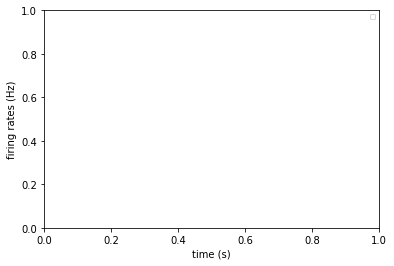

In [17]:
from bmtk.analyzer.visualization.spikes import plot_rates_popnet

cells_file = 'network/recurrent_network/node_types.csv'
rates_file = configure['output']['rates_file']
plot_rates_popnet(cells_file,rates_file,model_keys='pop_name')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2> Changing default parameters in the config </h2>

<p> Let's see some simple examples of changing default parameters in the config file.</div>

In [18]:
#Change duration of simulation from 3 seconds to 0.5 seconds
configure['run']['duration'] = 0.5

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p> Change firing rate and membrane time constant of input excitatory population (Ext) after checking the default value </div> 

In [19]:
#Get the default value of the input firing rate

# print(network.get_population('input_filter', 0))

print(network._nodeid2pop_map)
input_pop = network.get_population('Ext_input', 0)
print(input_pop.firing_rate)

input_pop.firing_rate = 25.0  # firing rate in Hz
print(input_pop.firing_rate)

exc_pop = network.get_population('V1', 0)
print(exc_pop['tau_m'])
exc_pop['tau_m'] = 0.2
print(exc_pop['tau_m'])


{'V1': {0: 0, 1: 1}, 'Ext_input': {0: 0}}
15.0
25.0
0.0429
0.2


In [21]:
# Rebuild network and run simulation using new config parameters 
network.rebuild()
sim.run()

[<dipde.internals.internalpopulation.InternalPopulation object at 0x7f6e8a6ede10>, <dipde.internals.internalpopulation.InternalPopulation object at 0x7f6e8a6edba8>, <dipde.internals.externalpopulation.ExternalPopulation object at 0x7f6e8a6edfd0>]
[<dipde.internals.connection.Connection object at 0x7f6e8a6ed8d0>, <dipde.internals.connection.Connection object at 0x7f6e8a6eda20>]
running simulation...
done simulation.


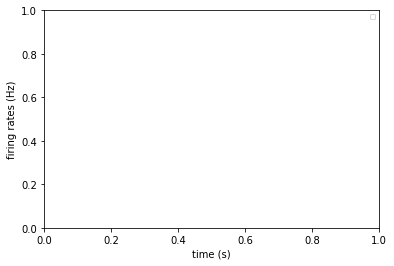

In [22]:
#Analyze outputs for new config

cells_file = 'network/recurrent_network/node_types.csv'
rates_file = configure['output']['rates_file']
plot_rates_popnet(cells_file,rates_file,model_keys='pop_name')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<h3> Exercise 1.3 : </h3>

<p>1) Add an I to E connection, 
<p>2) Save the edge,
<p>3) Build the network,
<p>4) Re-run the simulation to see how the outputs change.

<h3>NOTE: Make sure that the weight of the inhibitory connection is negative </h3> </div>

In [27]:
#connect I to E in net. You can specify edge params to be (id = 2, weight = -2 mV, delay = 5 ms
#and nsysns = 20)
#connect E to I in net
net.add_edges(source=net.nodes(pop_name = 'inhibitory'),
              target= net.nodes(pop_name = 'excitatory'),
              syn_weight=-0.002, 
              delay=0.002, 
              nsyns=20,
              dynamics_params='InhToExc.json')

#Build net
net.build()

#Save edge parameters
net.save_edges(edges_file_name='edges.h5', edge_types_file_name='edge_types.csv', output_dir=directory_name)

#Display what is contained in the edge_types file that you just saved
edge_types_DF = pd.read_csv('network/recurrent_network/edge_types2.csv', sep = ' ')
edge_types_DF

,edge_type_id,target_query,source_query,delay,syn_weight,dynamics_params,nsyns
0,100,pop_name=='inhibitory',pop_name=='excitatory',0.002,0.005,ExcToInh.json,20
1,101,pop_name=='excitatory',pop_name=='inhibitory',0.002,-0.002,InhToExc.json,20
2,102,pop_name=='excitatory',pop_name=='inhibitory',0.002,-0.002,InhToExc.json,20
3,103,pop_name=='excitatory',pop_name=='inhibitory',0.002,-0.002,InhToExc.json,20
4,104,pop_name=='excitatory',pop_name=='inhibitory',0.002,-0.002,InhToExc.json,20
5,105,pop_name=='excitatory',pop_name=='inhibitory',0.002,-0.002,InhToExc.json,20


2018-06-21 19:14:34,797 [INFO] Building cells.
2018-06-21 19:14:34,800 [INFO] Building recurrent connections
2018-06-21 19:14:34,812 [INFO] Build virtual cell stimulations for Ext_pop_rates
2018-06-21 19:14:34,828 [INFO] Network created.
[<dipde.internals.internalpopulation.InternalPopulation object at 0x7f6e8ab82470>, <dipde.internals.internalpopulation.InternalPopulation object at 0x7f6e8ab825f8>, <dipde.internals.externalpopulation.ExternalPopulation object at 0x7f6e8ab828d0>]
[<dipde.internals.connection.Connection object at 0x7f6e8ae56e80>, <dipde.internals.connection.Connection object at 0x7f6e8ab82d30>]
running simulation...
done simulation.


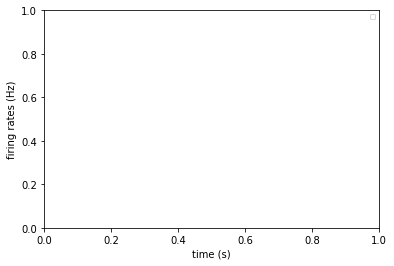

In [29]:
#Read in the config file and set run duration to 0.5 s
configure = popnet.config.from_json('config.json')
configure['run']['duration'] = 0.5

network = popnet.PopNetwork.from_config(configure)
sim = popnet.PopSimulator.from_config(configure, network)
sim.run()

#Analyze outputs
plot_rates_popnet(cells_file,rates_file,model_keys='pop_name')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px; \">
<h2>Homework exercises:</h2>
<p>1. Explore the directory structure created from this notebook that represents the network  
<p>2. Explore the directory components that was created for you and contains more cell types  
<p>3. Create a network with one E node and one (two) external population(s) providing excitatory (and/or inhibitory) inputs. Recurrently connect the E population to itself and simulate the network. Change the delay parameter for one of the edges and see if you are able to get oscillatory behavior.
<p>4. So far, we have been working with a single synaptic weight. Try exploring network topologies with different distributions of synaptic weights (for example, Gaussian with a given mean and variance) and and compare changes in output firing rates
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; \">
<h2>Project Ideas:</h2>
<p>1. Compare visual responses between the Layer 4 model and Brain Observatory.  

<p>2. Find an optimal kernel for converting spikes from the Layer 4 model to Ca2+ signal, to maximize the agreeement with the Brain Observatory data.  

<p>3. Build a small-scale point-neuron network model receiving visual inputs; run simulations to explore visual responses.  

<p>4. Build a small-scale point-neuron network; explore the effect of different connectivity rules on the spatio-temporal dynamics.  

<p>5. Build a population-statistics DiPDE model analogous to the biophysical Layer 4 model.  Investigate whether similar dynamics can be obtained.  

<p>6. Build a population-statistics DiPDE model of all cortical layers.  Explore cortical dynamics in simulations.  
</div>